# Motivating examples of Bayesian Data Science

Now that we've seen the most important theoretical underpinnings of the Bayesian statistical paradigm, we can jump in to model-building and using MCMC to do wonderful things.

## Evaluating Hypotheses with Bayes

In particular, the *de facto* standard for statistical inference is statistical hypothesis testing. The goal of hypothesis testing is to evaluate a **null hypothesis**. There are two possible outcomes:

- reject the null hypothesis
- fail to reject the null hypothesis

Rejection occurs when a chosen test statistic is higher than some pre-specified threshold value; non-rejection occurs otherwise.

Notice that neither outcome says anything about the quantity of interest, the **research hypothesis**. 

Setting up a statistical test involves several subjective choices by the user that are rarely justified based on the problem or decision at hand:

- statistical test to use
- null hypothesis to test
- significance level

Choices are often based on arbitrary criteria, including "statistical tradition" (Johnson 1999). The resulting evidence is indirect, incomplete, and typically overstates the evidence against the null hypothesis (Goodman 1999).

Most importantly to applied users, the results of statistical hypothesis tests are very easy to misinterpret. 

### Estimation 

Instead of testing, a more informative and effective approach for inference is based on **estimation** (be it frequentist or Bayesian). That is, rather than testing whether two groups are different, we instead pursue an estimate of *how different* they are, which is fundamentally more informative. 

Additionally, we include an estimate of **uncertainty** associated with that difference which includes uncertainty due to our lack of knowledge of the model parameters (*epistemic uncertainty*) and uncertainty due to the inherent stochasticity of the system (*aleatory uncertainty*).

## One Group

Before we compare two groups using Bayesian analysis, let's start with an even simpler scenario: statistical inference for one group.

For this we will use Gelman et al.'s (2007) radon dataset. In this dataset the amount of the radioactive gas radon has been measured among different households in all counties of several US states. Radon gas is known to be the highest cause of lung cancer in non-smokers. It is believed to be more strongly present in households containing a basement and to differ in amount present among types of soil.

>  the US EPA has set an action level of 4 pCi/L. At or above this level of radon, the EPA recommends you take corrective measures to reduce your exposure to radon gas.

![radon](images/how_radon_enters.jpg)

Let's import the dataset:

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm

In [2]:
RANDOM_SEED = 8929
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [3]:
radon = pd.read_csv("../data/radon.csv", index_col=0)
radon.head()

,idnum,state,state2,stfips,zip,region,typebldg,floor,room,basement,...,pcterr,adjwt,dupflag,zipflag,cntyfips,county,fips,Uppm,county_code,log_radon
0,5081.0,MN,MN,27.0,55735,5.0,1.0,1.0,3.0,N,...,9.7,1146.499190,1.0,0.0,1.0,AITKIN,27001.0,0.502054,0,0.832909
1,5082.0,MN,MN,27.0,55748,5.0,1.0,0.0,4.0,Y,...,14.5,471.366223,0.0,0.0,1.0,AITKIN,27001.0,0.502054,0,0.832909
2,5083.0,MN,MN,27.0,55748,5.0,1.0,0.0,4.0,Y,...,9.6,433.316718,0.0,0.0,1.0,AITKIN,27001.0,0.502054,0,1.098612
3,5084.0,MN,MN,27.0,56469,5.0,1.0,0.0,4.0,Y,...,24.3,461.623670,0.0,0.0,1.0,AITKIN,27001.0,0.502054,0,0.095310
4,5085.0,MN,MN,27.0,55011,3.0,1.0,0.0,4.0,Y,...,13.8,433.316718,0.0,0.0,3.0,ANOKA,27003.0,0.428565,1,1.163151


Let's focus on the (log) radon levels measured in a single county (Hennepin). 

Suppose we are interested in:

- whether the mean log-radon value is greater than 4 pCi/L in Hennepin county
- the probability that any randomly-chosen household in Hennepin county has a reading of greater than 4

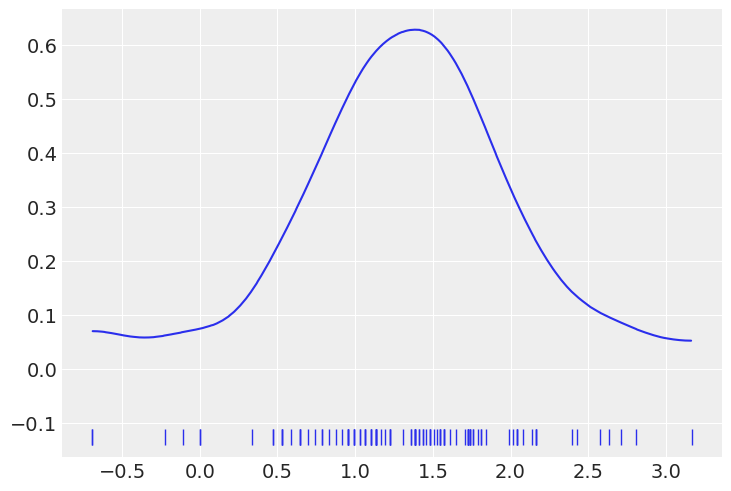

In [4]:
hennepin_radon = radon.query('county=="HENNEPIN"').log_radon
az.plot_dist(hennepin_radon, rug=True);

### The model

Recall that the first step in Bayesian inference is specifying a **full probability model** for the problem.

This consists of:

- a likelihood function(s) for the observations
- priors for all unknown quantities

The measurements look approximately normal, so let's start by assuming a normal distribution as the sampling distribution (likelihood) for the data. 

$$y_i \sim N(\mu, \sigma^2)$$

(don't worry, we can evaluate this assumption)

This implies that we have 2 unknowns in the model; the mean and standard deviation of the distribution. 

#### Prior choice

How do we choose distributions to use as priors for these parameters? 

There are several considerations:

- discrete vs continuous values
- the support of the variable
- the available prior information

While there may likely be prior information about the distribution of radon values, we will assume no prior knowledge, and specify a **diffuse** prior for each parameter.

Since the mean can take any real value (since it is on the log scale), we will use another normal distribution here, and specify a large variance to allow for the possibility of very large or very small values:

$$\mu \sim N(0, 5^2)$$

For the standard deviation, we know that the true value must be positive (no negative variances!). I will choose a weakly regularizing prior: an $Exponential(1)$ distribution, where most of the probability mass is assured to include any plausible values the true standard deviation (on the log scale) could take.

$$\sigma \sim Exponential(1)$$

We can encode these in a Python model, using the PyMC3 package, as follows:

In [5]:
with pm.Model() as radon_model:
    μ = pm.Normal("μ", mu=0, sigma=5)
    σ = pm.Exponential("σ", 1.0)

> ## Software
> Today there is an array of software choices for Bayesians, including both open source software (*e.g.*, Stan, PyMC, Pyro, TensorFlow Probability) and commercial (*e.g.*, SAS, Stata). These examples can be replicated in any of these environments.

All that remains is to add the likelihood, which takes $\mu$ and $\sigma$ as parameters, and the log-radon values as the set of observations:

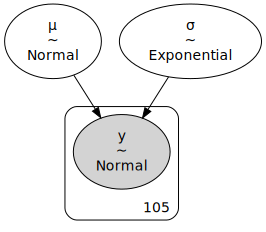

In [6]:
with radon_model:
    y = pm.Normal("y", mu=μ, sigma=σ, observed=hennepin_radon)

pm.model_to_graphviz(radon_model)

Before we go ahead and estimate the model paramters from the data, it's a good idea to perform a **prior predictive check**. This involves sampling from the model before data are incorporated, and gives you an idea of the range of observations that would be considered reasonable within the scope of the modeling assumptions (including choice of priors). If the simulations generate too many extreme observations relative to our expectations based on domain knowledge, then it can be an indication of problems with model formulation.

In [7]:
with radon_model:
    prior_checks = pm.sample_prior_predictive(random_seed=RANDOM_SEED)

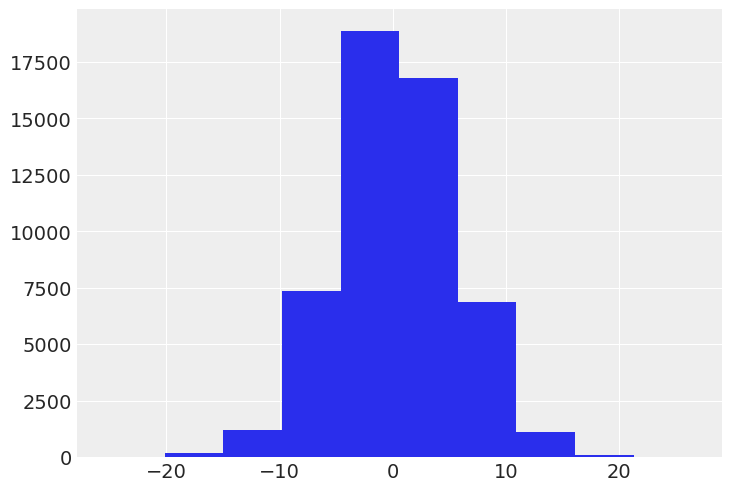

In [8]:
plt.hist(prior_checks["y"].ravel());

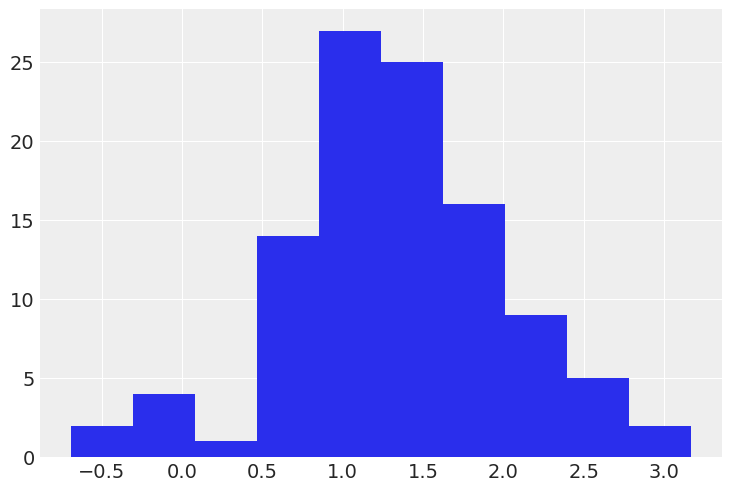

In [9]:
plt.hist(hennepin_radon);

Now, we will fit the model using **Markov chain Monte Carlo (MCMC)**, which will be covered in detail in an upcoming section. This will draw samples from the posterior distribution (which cannot be calculated exactly).

In [10]:
with radon_model:
    samples = pm.sample(random_seed=RANDOM_SEED, return_inferencedata=True)
az.summary(samples, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, μ]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ,1.32,0.07,1.18,1.44,0.0,0.0,1816.96,1171.73,1.0
σ,0.69,0.05,0.60,0.78,0.0,0.0,1543.75,1297.84,1.0


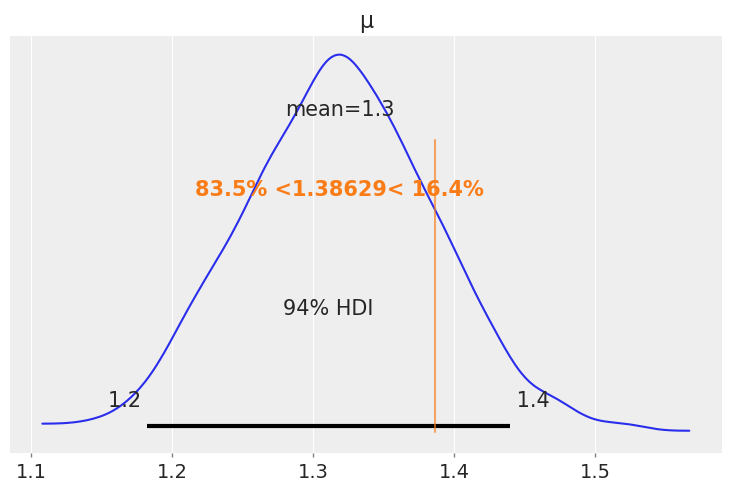

In [11]:
az.plot_posterior(samples, var_names=["μ"], ref_val=np.log(4));

The plot shows the posterior distribution of $\mu$, along with an estimate of the 94% posterior **credible interval**. 

The output

    84% < 1.38629 < 16%
    
informs us that the probability of $\mu$ being less than $log(4)$ is 84% and the corresponding probability of being greater than $log(4)$ is 16%.

> The posterior probability that the mean level of household radon in Henneprin County is greater than 4 pCi/L is 0.16.

### Prediction

What is the probability that a given household has a log-radon measurement larger than $log(4)$? To answer this, we make use of the **posterior predictive distribution**:

$$p(z |y) = \int_{\theta} p(z |\theta) p(\theta | y) d\theta$$

where $z$ is the predicted value and $y$ is the data used to fit the model.

We can estimate this from the posterior samples of the parameters in the model:

In [12]:
mus = samples.posterior["μ"]
sigmas = samples.posterior["σ"]

In [13]:
radon_samples = pm.Normal.dist(mus, sigmas).random()

In [14]:
(radon_samples > np.log(4)).mean().round(2)

0.46

Or we can do that directly with PyMC3:

In [15]:
with radon_model:
    ppc = pm.sample_posterior_predictive(samples, random_seed=RANDOM_SEED)
    samples.extend(az.from_pymc3(posterior_predictive=ppc))

In [16]:
(ppc["y"] > np.log(4)).mean().round(2)

0.46

> The posterior probability that a randomly-selected household in Henneprin County contains radon levels in excess of 4 pCi/L is about 0.46.

### Model checking

But, ***how do we know this model is any good?***

It's important to check the fit of the model, to see if its assumptions are reasonable. One way to do this is to perform **posterior predictive checks**. This involves generating simulated data using the model that you built, and comparing that data to the observed data.

One can choose a particular statistic to compare, such as tail probabilities or quartiles, but here it is useful to compare them graphically.

We already have these simulations from the previous exercise!

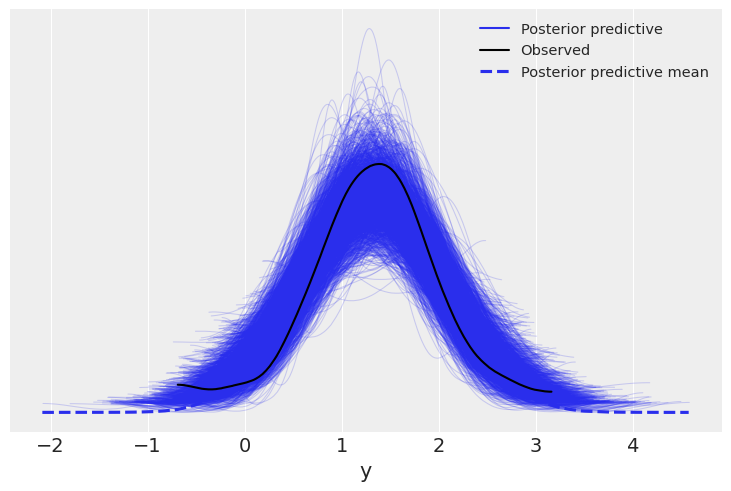

In [17]:
az.plot_ppc(samples);

### Exercise: Prior sensitivity

Its important to check the sensitivity of your choice of priors to the resulting inference. Specify the radon model using different priors for the mean and standard deviation. [For reference, here is a link to the probability distributions API for PyMC3](https://docs.pymc.io/api/distributions.html), which lists the available distributions.

Think hard about the desirable properties of priors for each variable.

In [ ]:
with pm.Model() as prior_sensitivity:
    μ = ?
    σ = ?
    
    dist = pm.Normal('dist', mu=μ, sigma=σ, observed=hennepin_radon)
    
    sensitivity_samples = pm.sample()

In [ ]:
az.plot_posterior(sensitivity_samples, var_names=["μ"], ref_val=np.log(4));

Here is the original model for comparison:

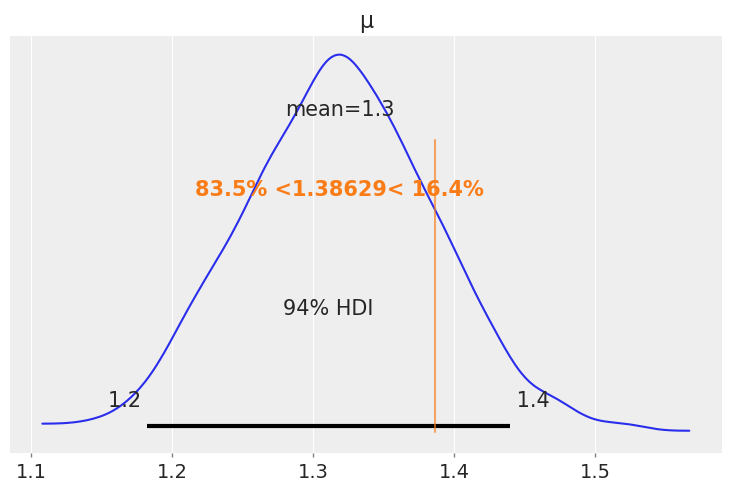

In [18]:
az.plot_posterior(samples, var_names=["μ"], ref_val=np.log(4));

## Two Groups with Continuous Outcome

To illustrate how this Bayesian estimation approach works in practice, we will use a fictitious example from Kruschke (2012) concerning the evaluation of a clinical trial for drug evaluation. The trial aims to evaluate the efficacy of a "smart drug" that is supposed to increase intelligence by comparing IQ scores of individuals in a treatment arm (those receiving the drug) to those in a control arm (those recieving a placebo). There are 47 individuals and 42 individuals in the treatment and control arms, respectively.

/home/lpaz/anaconda3/envs/bayes_workshop/lib/python3.9/site-packages/pandas/plotting/_matplotlib/hist.py:297: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.subplots_adjust(


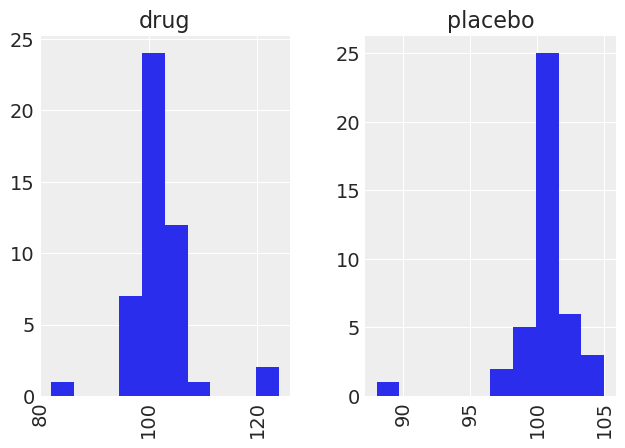

In [19]:
# fmt: off
drug = pd.DataFrame(
    dict(
        iq=(
            101,100,102,104,102,97,105,105,98,101,100,123,105,103,100,95,102,106,
            109,102,82,102,100,102,102,101,102,102,103,103,97,97,103,101,97,104,
            96,103,124,101,101,100,101,101,104,100,101
        ),
        group='drug'
    )
)
placebo = pd.DataFrame(
    dict(
        iq=(
            99,101,100,101,102,100,97,101,104,101,102,102,100,105,88,101,100,
            104,100,100,100,101,102,103,97,101,101,100,101,99,101,100,100,
            101,100,99,101,100,102,99,100,99
        ),
        group='placebo'
    )
)
trial_data = pd.concat([drug, placebo], ignore_index=True)
trial_data.hist('iq', by='group');
# fmt: on

Since there appear to be extreme ("outlier") values in the data, we will choose a Student-t distribution to describe the distributions of the scores in each group. This sampling distribution adds **robustness** to the analysis, as a T distribution is less sensitive to outlier observations, relative to a normal distribution. 

The three-parameter Student-t distribution allows for the specification of a mean $\mu$, a precision (inverse-variance) $\lambda$ and a degrees-of-freedom parameter $\nu$:

$$f(x|\mu,\lambda,\nu) = \frac{\Gamma(\frac{\nu + 1}{2})}{\Gamma(\frac{\nu}{2})} \left(\frac{\lambda}{\pi\nu}\right)^{\frac{1}{2}} \left[1+\frac{\lambda(x-\mu)^2}{\nu}\right]^{-\frac{\nu+1}{2}}$$
           
the degrees-of-freedom parameter essentially specifies the "normality" of the data, since larger values of $\nu$ make the distribution converge to a normal distribution, while small values (close to zero) result in heavier tails.

Thus, the likelihood functions of our model are specified as follows:

$$\begin{align}
y^{(drug)}_i &\sim T(\nu, \mu_1, \sigma_1) \\
y^{(placebo)}_i &\sim T(\nu, \mu_2, \sigma_2)
\end{align}$$

As a simplifying assumption, we will assume that the degree of normality $\nu$ is the same for both groups. 

### Prior choice

Since the means are real-valued, we will apply normal priors. Since we know something about the population distribution of IQ values, we will center the priors at 100, and use a standard deviation that is more than wide enough to account for plausible deviations from this population mean:

$$\mu_k \sim N(100, 10^2)$$

In [20]:
coords = {"arm": ["placebo", "drug"]}

with pm.Model(coords=coords) as drug_model:
    μ = pm.Normal("μ", 100.0, sigma=10.0, dims="arm")

Similarly, we will use a classic $Exponential(1)$ distribution for the prior on the standard deviations:

In [21]:
with drug_model:
    σ = pm.Exponential("σ", 1.0, dims="arm")

For the degrees-of-freedom parameter $\nu$, we will use an **exponential** distribution with a mean of 30; this allocates high prior probability over the regions of the parameter that describe the range from normal to heavy-tailed data under the Student-T distribution.

In [22]:
with drug_model:
    ν = pm.Exponential("ν_minus_one", 1 / 29.0) + 1

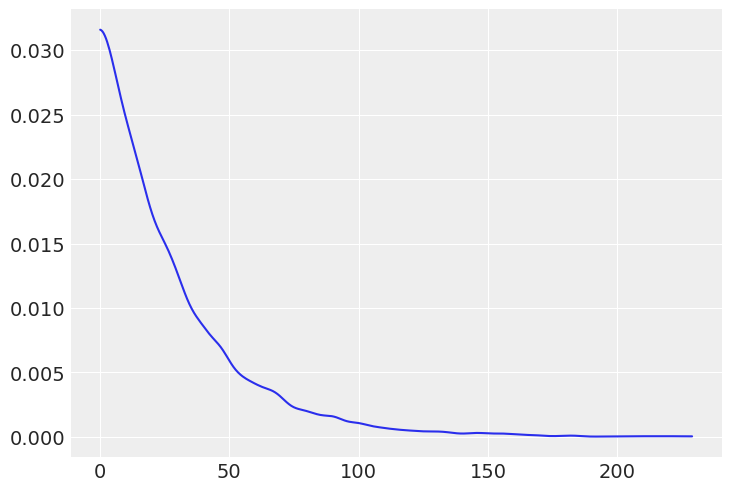

In [23]:
az.plot_dist(pm.Exponential.dist(1 / 29).random(size=10000));

In [24]:
with drug_model:
    placebo_like = pm.StudentT(
        "placebo_like", nu=ν, mu=μ[0], lam=σ[0] ** -2, observed=placebo.iq
    )
    drug_like = pm.StudentT(
        "drug_like", nu=ν, mu=μ[1], lam=σ[1] ** -2, observed=drug.iq
    )

Now that the model is fully specified, we can turn our attention to tracking the posterior quantities of interest. Namely, we can calculate the difference in means between the drug and placebo groups.

As a joint measure of the groups, we will also estimate the "effect size", which is the difference in means scaled by the pooled estimates of standard deviation. This quantity can be harder to interpret, since it is no longer in the same units as our data, but it is a function of all four estimated parameters:

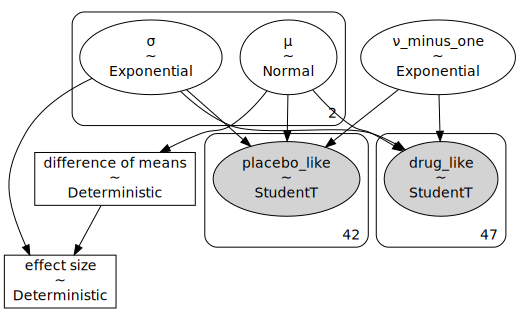

In [25]:
with drug_model:
    diff_of_means = pm.Deterministic("difference of means", μ[1] - μ[0])
    effect_size = pm.Deterministic(
        "effect size", diff_of_means / np.sqrt((σ[0] ** 2 + σ[1] ** 2) / 2)
    )

pm.model_to_graphviz(drug_model)

In [26]:
with drug_model:
    drug_trace = pm.sample(
        tune=2000, random_seed=RANDOM_SEED, return_inferencedata=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ν_minus_one, σ, μ]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 12 seconds.


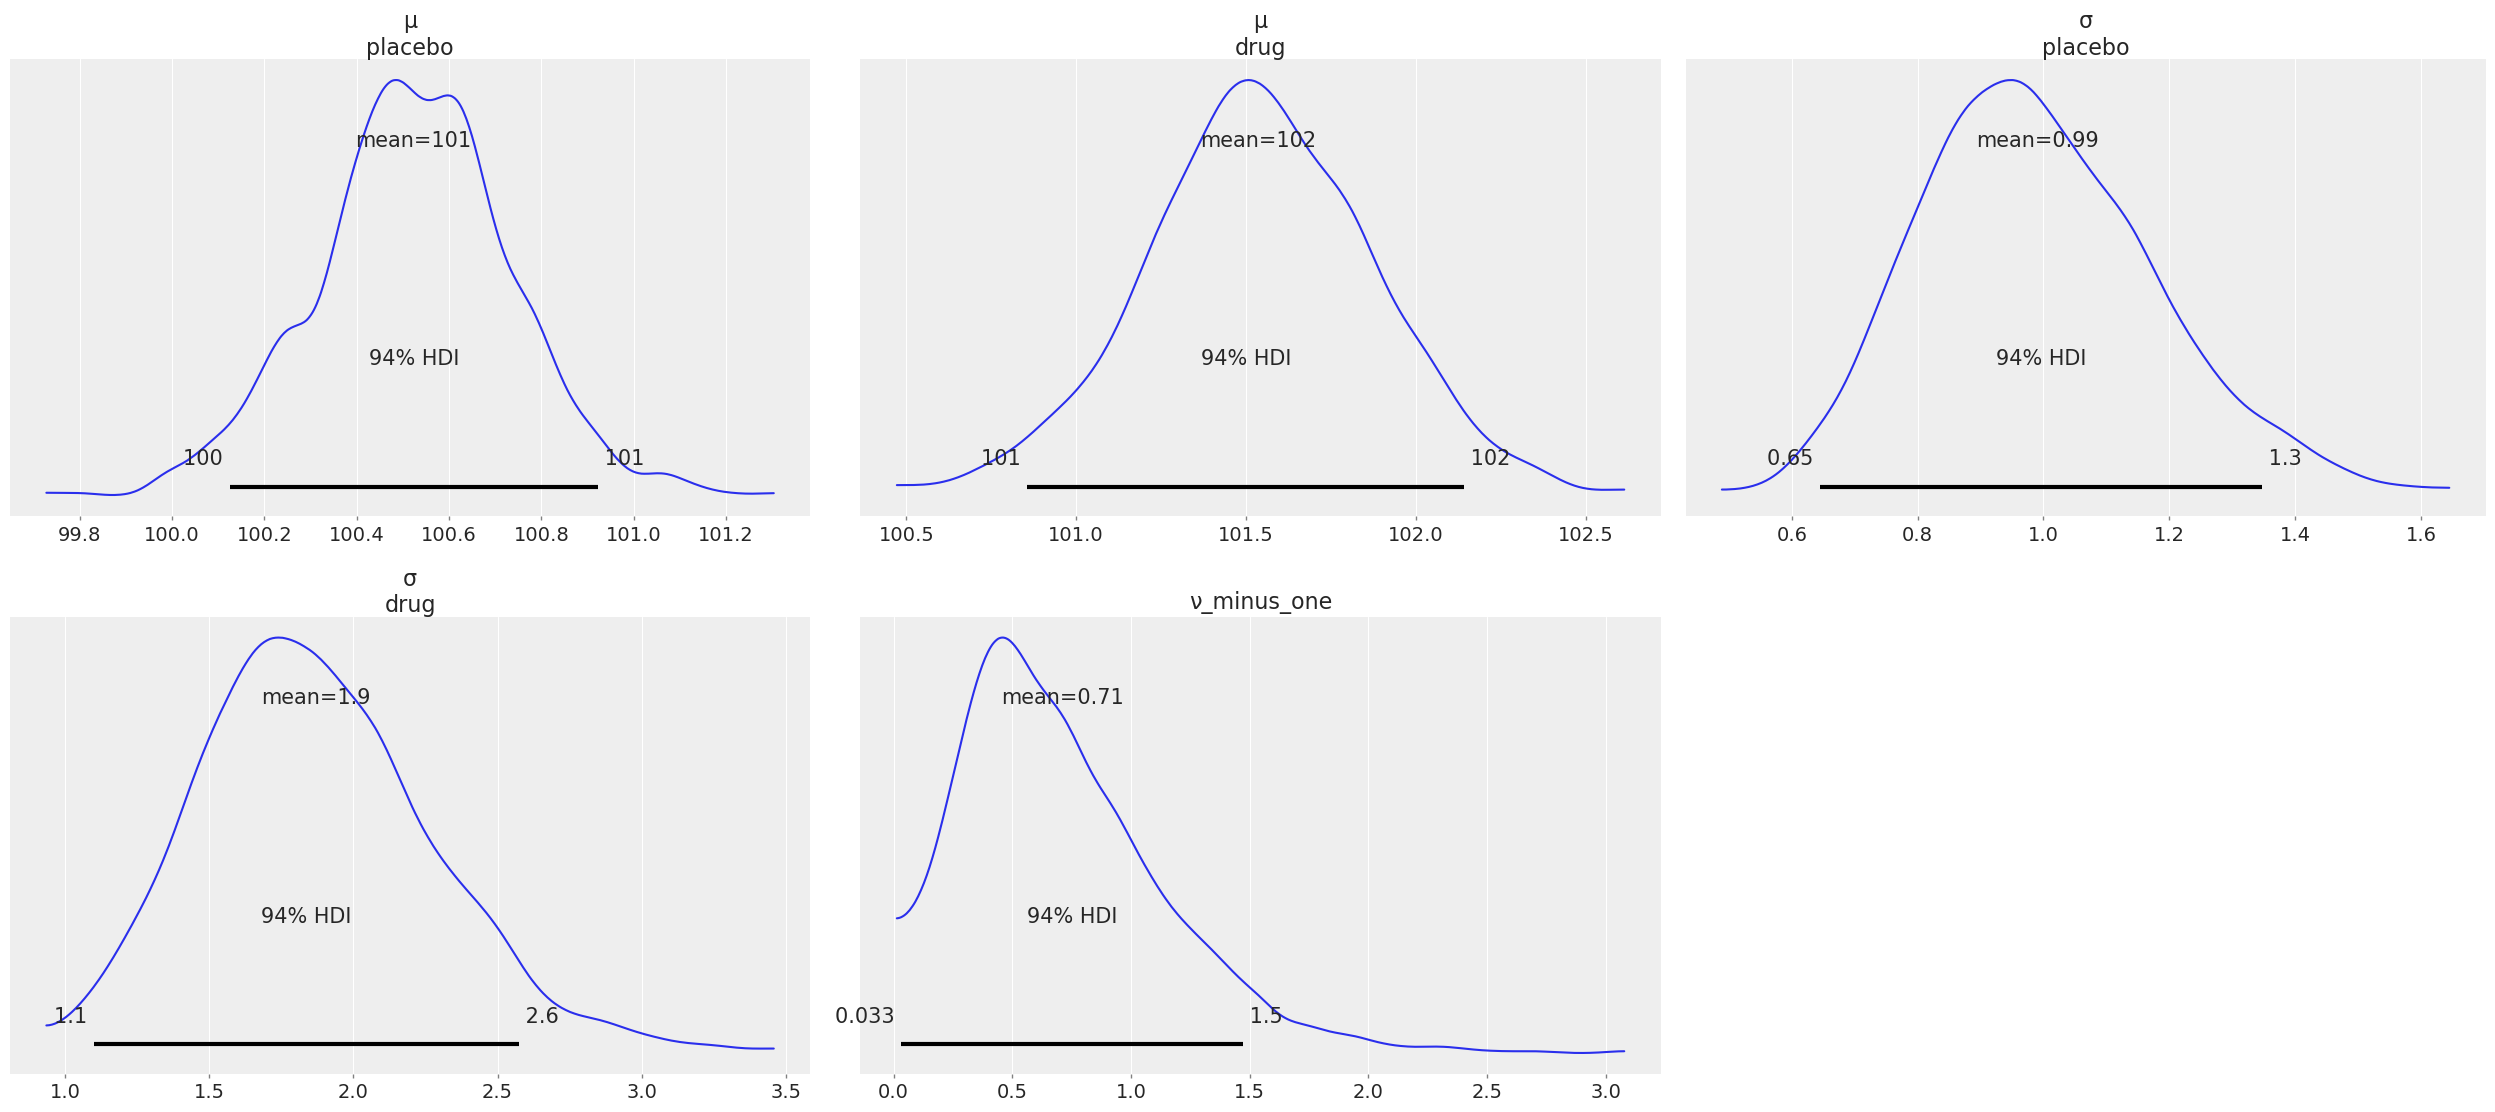

In [27]:
az.plot_posterior(drug_trace, var_names=["~difference of means", "~effect size"]);

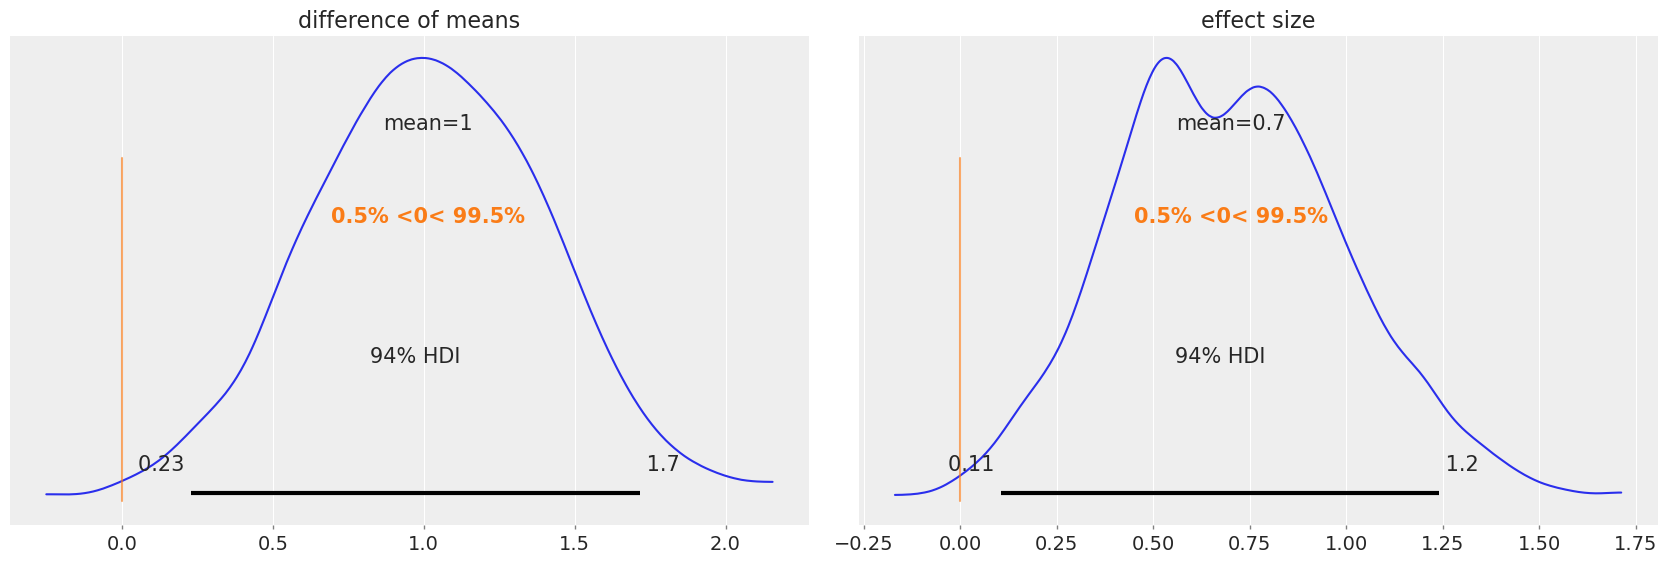

In [28]:
az.plot_posterior(
    drug_trace, var_names=["difference of means", "effect size"], ref_val=0
);

> The posterior probability that the mean IQ of subjects in the treatment group is greater than that of the control group is 0.99.

## Linear regression

This last example could also be formulated as a linear regression problem. We could think that the general population has some distribution of IQ's, and that the drug has some effect, $\beta$, on the mean of the distribution.

$$
\mu_{population} \sim N(0, 10)\\
\beta \sim N(0, 10)\\
\sigma \sim Exponential(1)\\
\nu \sim Exponential(\frac{1}{29}) + 1\\
\mu_{subject} = \mu_{population} + \beta x_{subject}\\
IQ_{i} \sim \text{Student-t}(\mu_{subject}, \sigma_{x_{subject}}, \nu)\\
$$

where $x_{subject}$ is a regressor that is 0 if a placebo was provided and 1 if the "smart drug" was administered to the subject.

To allow our regression to have the same flexibility as our previous analysis, we allow the standard deviation, $\sigma$, to vary across groups (placebo and drug), but usually $\sigma$ is assumed to be common to both groups.

The powerful feature of this regression is that **$\beta$ estimates the expected difference in the mean IQ that arises due to the drug**.

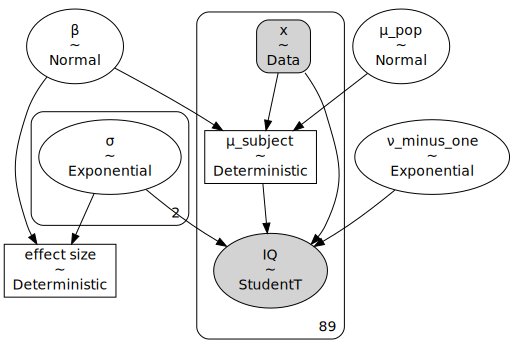

In [29]:
subject_idx = trial_data.index.to_numpy()
coords = {"arm": ["placebo", "drug"], "subject_idx": subject_idx}

with pm.Model(coords=coords) as linear_regression:
    μ_pop = pm.Normal("μ_pop", 100.0, 10.0)
    β = pm.Normal("β", 0, 5)
    σ = pm.Exponential("σ", 1.0, dims="arm")
    ν = pm.Exponential("ν_minus_one", 1 / 29.0) + 1
    x = pm.Data("x", (trial_data.group == "drug").to_numpy().astype("int"))
    μ_subject = pm.Deterministic("μ_subject", μ_pop + β * x, dims="subject_idx")
    
    IQ = pm.StudentT(
        "IQ", nu=ν, mu=μ_subject, lam=σ[x] ** -2, observed=trial_data.iq, dims="subject_idx"
    )
    effect_size = pm.Deterministic(
        "effect size", β / np.sqrt((σ[0] ** 2 + σ[1] ** 2) / 2)
    )

pm.model_to_graphviz(linear_regression)

In [30]:
with linear_regression:
    linear_regression_trace = pm.sample(
        tune=2000, random_seed=RANDOM_SEED, return_inferencedata=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ν_minus_one, σ, β, μ_pop]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 11 seconds.


0, dim: subject_idx, 89 =? 89


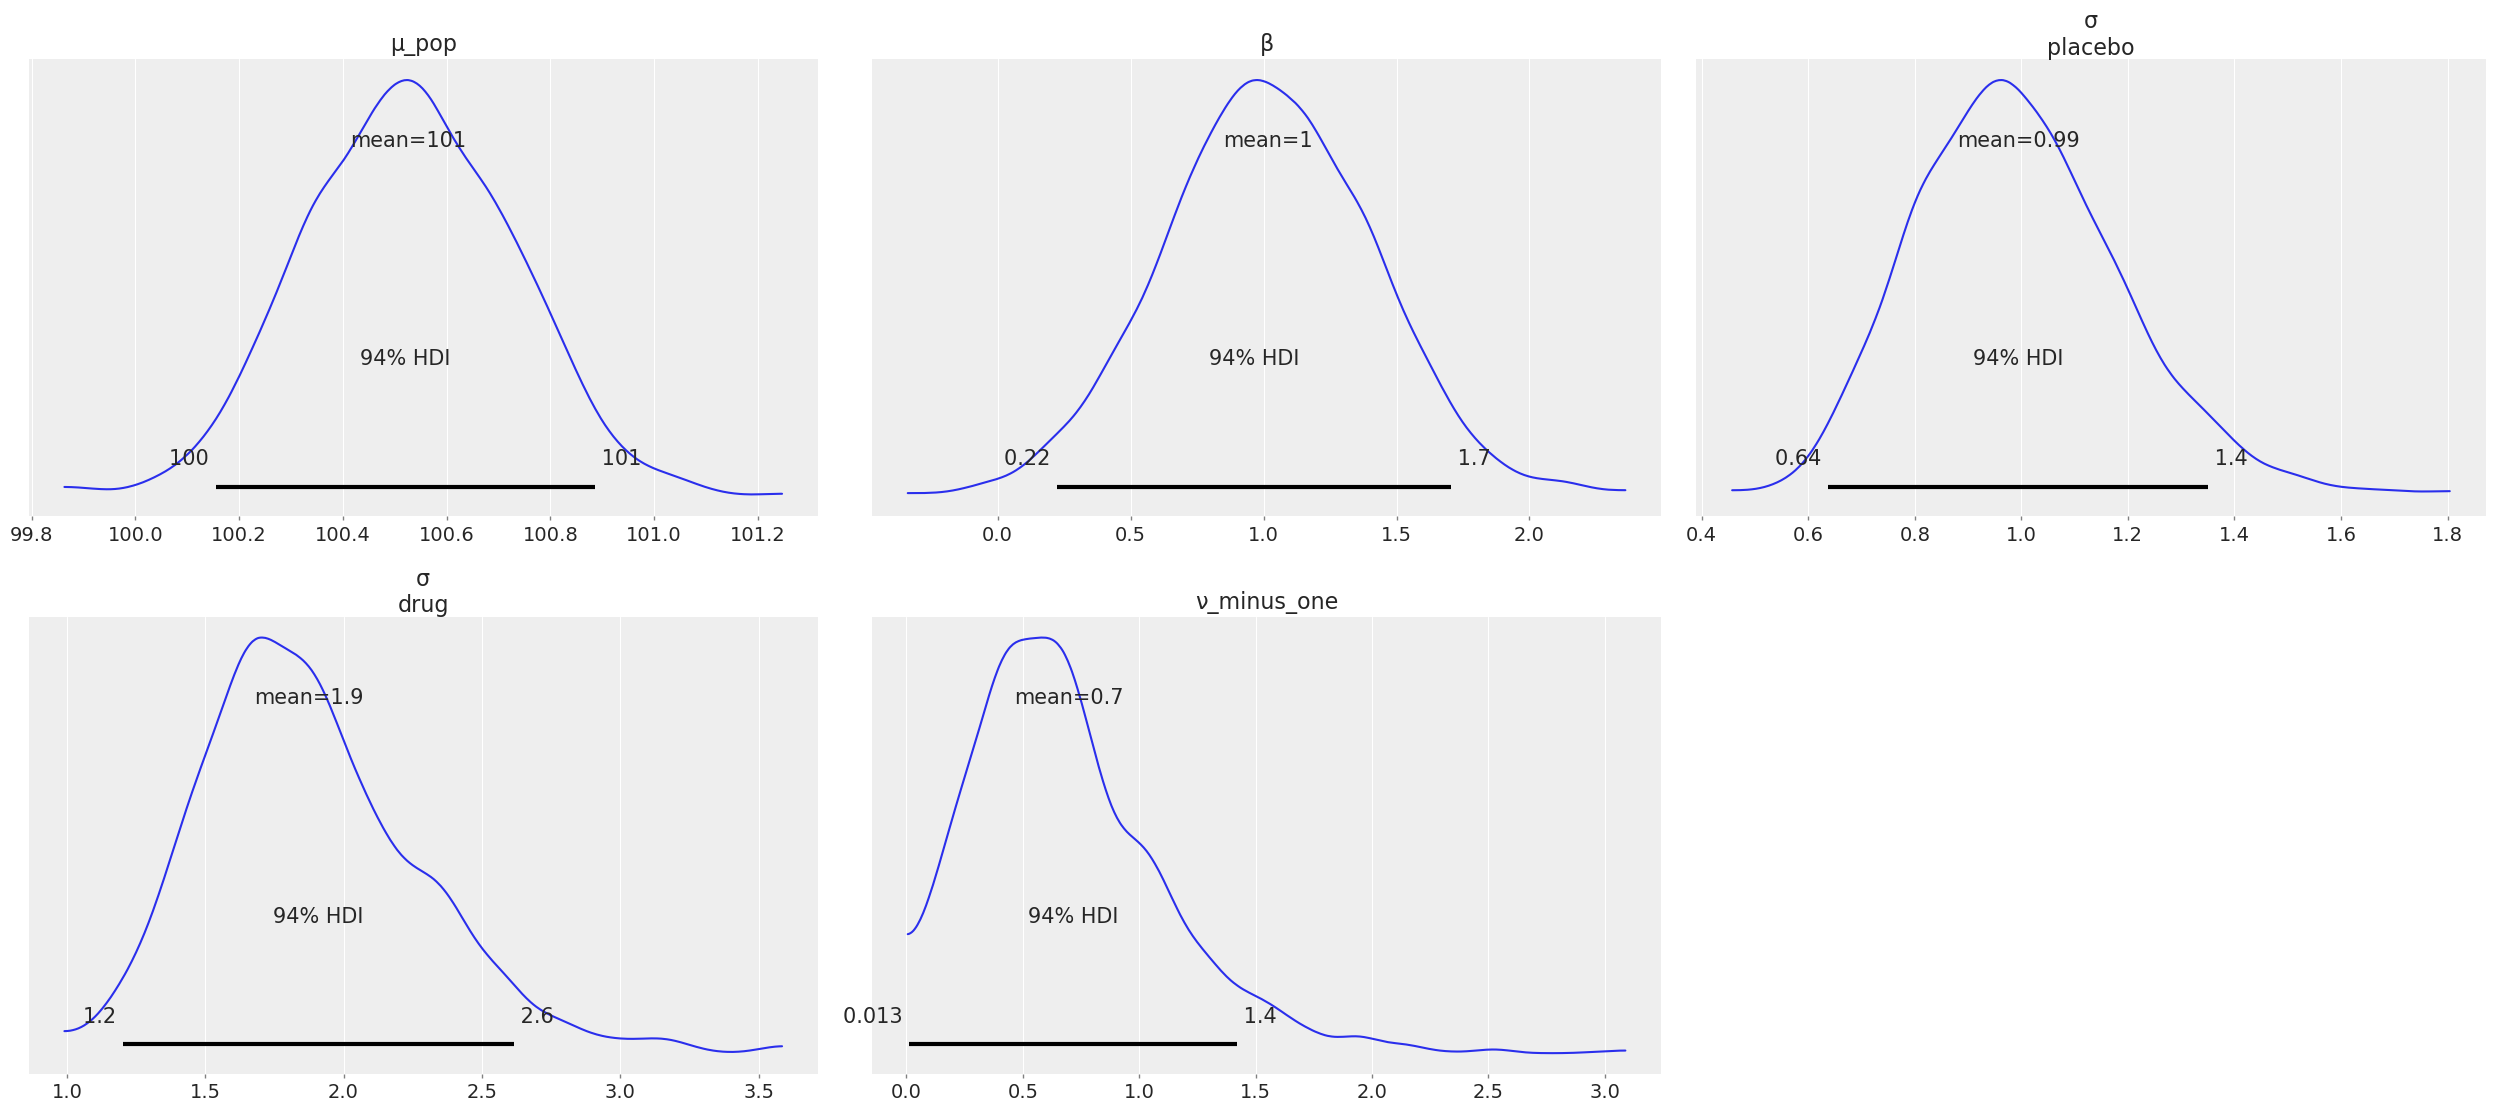

In [31]:
az.plot_posterior(linear_regression_trace, var_names=["~μ_subject", "~effect size"]);

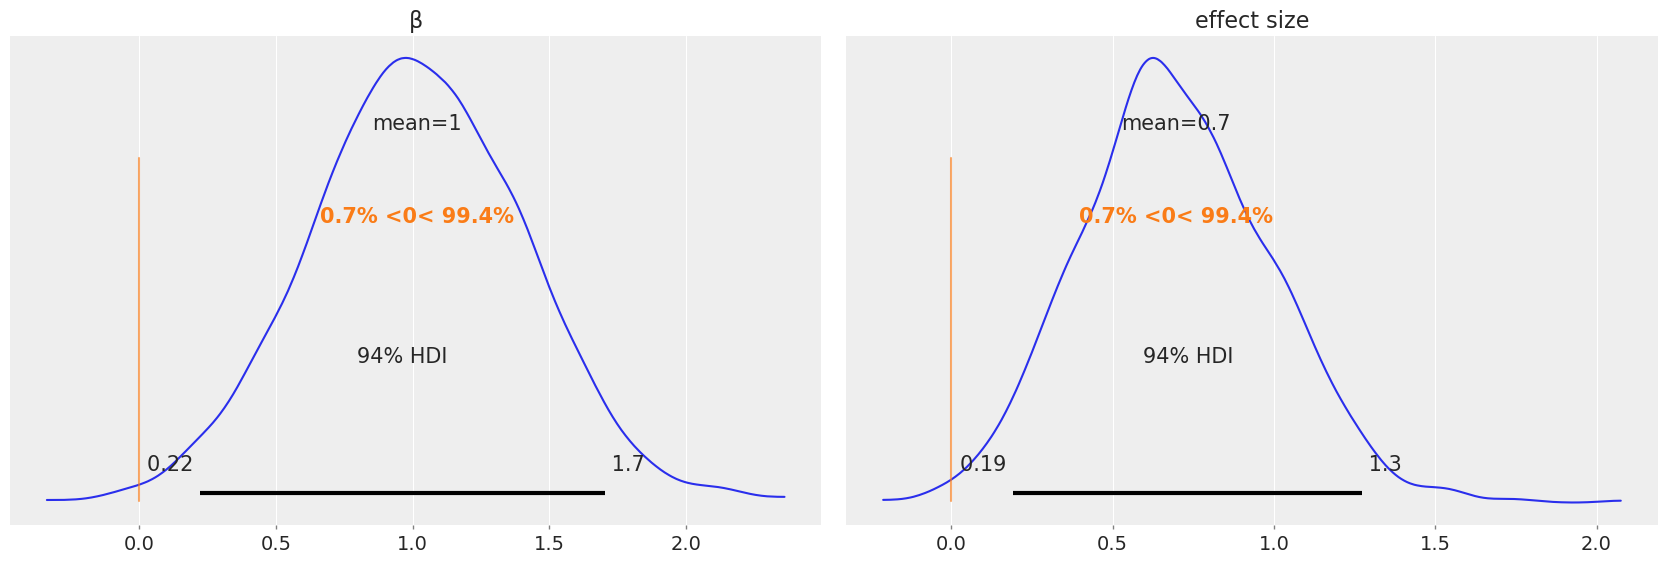

In [32]:
az.plot_posterior(
    linear_regression_trace, var_names=["β", "effect size"], ref_val=0
);

As you can all see, our results for this linear regression matches with our previous results.

---

## References

Gelman, Andrew, John B. Carlin, Hal S. Stern, David B. Dunson, Aki Vehtari, and Donald B. Rubin, 2013, _Bayesian Data Analysis_, Third Edition. CRC Press.

Pilon, Cam-Davidson. [Probabilistic Programming and Bayesian Methods for Hackers](http://camdavidsonpilon.github.io/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/)

In [33]:
%load_ext watermark
%watermark -n -u -v -iv

Last updated: Wed Mar 24 2021

Python implementation: CPython
Python version       : 3.9.2
IPython version      : 7.21.0

pandas    : 1.2.3
arviz     : 0.11.2
numpy     : 1.20.1
pymc3     : 3.11.2
matplotlib: 3.3.4

